In [16]:
%matplotlib inline
import emcee
import numpy as np
import matplotlib.pyplot as plt
import os, sys, time, math
import torch
from tqdm import tqdm
from torch.multiprocessing import Pool#, set_start_method
from getdist import plots, MCSamples
import getdist

sys.path.append('/home/joeadamo/Research') #<- parent directory of dark emulator code
from DarkEmuPowerRSD import pkmu_nn, pkmu_hod
from CovNet import CovNet

In [18]:
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
training_dir = "/home/joeadamo/Research/CovNet/Data/Training-Set/"
data_dir =  "/home/joeadamo/Research/CovNet/Data/"
PCA_dir = "/home/joeadamo/Research/CovNet/Data/PCA-Set/"
BOSS_dir = "/home/joeadamo/Research/Data/BOSS-DR12/"
CovaPT_dir = "/home/joeadamo/Research/CovaPT/Example-Data/"

In [4]:
cosmo_prior = np.array([[66.5, 75.5],
                        [0.10782, 0.13178],
                        [0.0211375, 0.0233625],
                        [1.1885e-9, 2.031e-9],#[2.4752, 3.7128],
                        [1.806, 2.04],
                        [-2.962, 0.458]])

cosmo_fid = np.array([69,0.1198,0.02225,2e-9,1.4,0.])

gparams = {'logMmin': 13.9383, 'sigma_sq': 0.7918725**2, 'logM1': 14.4857, 'alpha': 1.19196,  'kappa': 0.600692, 
          'poff': 0.0, 'Roff': 2.0, 'alpha_inc': 0., 'logM_inc': 0., 'cM_fac': 1., 'sigv_fac': 1., 'P_shot': 0.}
redshift = 0.5

In [5]:
P_BOSS = np.loadtxt(BOSS_dir+"Cl-BOSS-DR12.dat")
pgg = pkmu_hod()

data_vector = np.concatenate((P_BOSS[1], P_BOSS[2]))

def model_vector(params, gparams):
    """
    Calculates the model vector using Yosuke's galaxy power spectrum emulator
    """
    #print(params)
    h = params[0] / 100
    omch2 = params[1]
    ombh2 = params[2]
    #assert omch2 <= 0.131780
    As = np.log(1e10 * params[3])
    #assert As >= 2.47520
    ns = 0.965
    Om0 = (omch2 + ombh2 + 0.00064) / (h**2)
    
    # rebuild parameters into correct format (ombh2, omch2, 1-Om0, ln As, ns, w)
    cparams = np.array([ombh2, omch2, 1-Om0, As, ns, -1])
    redshift = 0.5
    k = np.linspace(0.005, 0.25, 50)
    mu = np.linspace(0.1,0.9,4)
    alpha_perp = 1.1
    alpha_para = 1

    pgg.set_cosmology(cparams, redshift)
    pgg.set_galaxy(gparams)
    P0_emu = pgg.get_pl_gg_ref(0, k, alpha_perp, alpha_para, name='total')
    P2_emu = pgg.get_pl_gg_ref(2, k, alpha_perp, alpha_para, name='total')
    return np.concatenate((P0_emu, P2_emu))

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


In [42]:
# load in the mcmc chain from file
N    = 100
NDIM = 6
chain = np.load(data_dir+"mcmc_chains.npy")

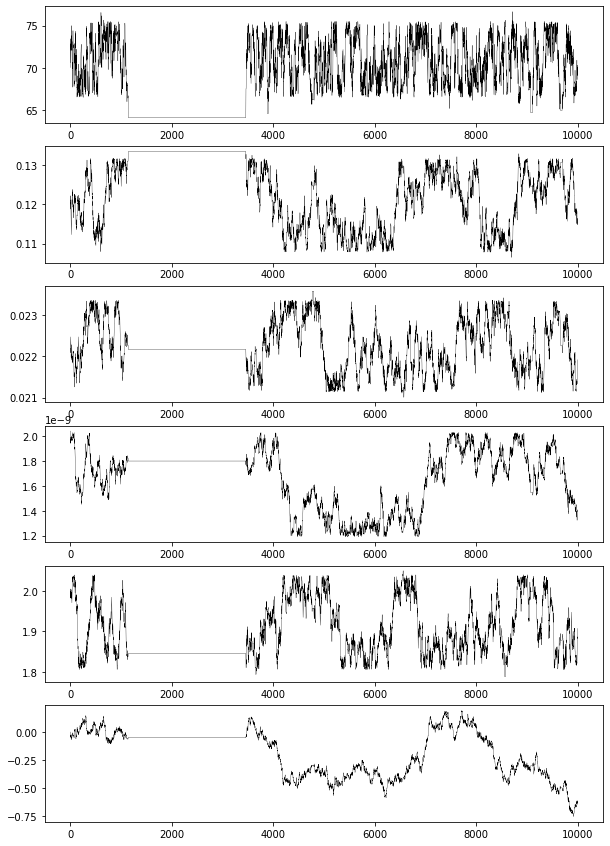

In [43]:
fig, ax = plt.subplots(NDIM,1,figsize=(10, 2.5 * NDIM))
for i in range(NDIM):
    ax[i].plot(chain[:,i].T, 'k-', lw=0.3)
plt.show()  

In [44]:
N_BURN_IN = 3800

samples = chain[N_BURN_IN:, :].reshape((-1,NDIM))

In [47]:
def plot_cosmo_contours(sample_list, legend_labels):
    names = ['H0', 'omegac', 'omegab', 'As', 'b1', 'b2']
    labels =  ["H_0", '\omega_c', '\omega_b', 'A_s', 'b1', 'b2']
    
    cosmo_truth = [69., 0.1199772, 0.0228528, 2e-9, 1.9485, -0.5386]
    truth_dict = {}
    for name, truth in zip(names, cosmo_truth):
        truth_dict[name] = truth
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = samples[:,:6]
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True, markers=truth_dict)
    
    plt.show()

Removed no burn in


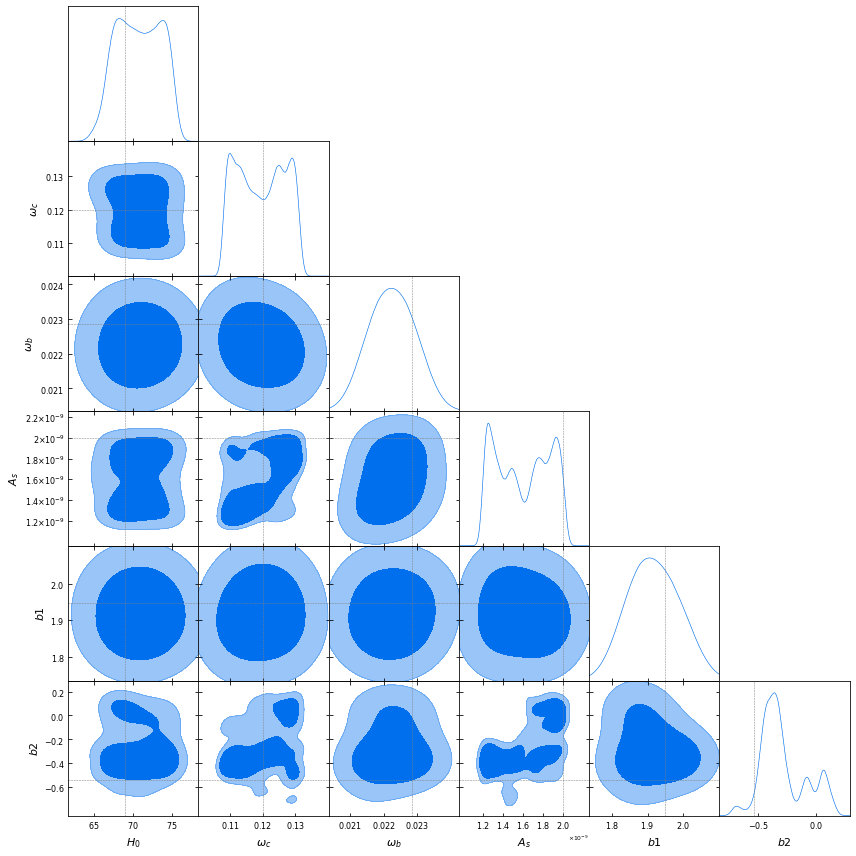

In [48]:
plot_cosmo_contours([samples], ['posterior'])